Values for the Juptier with alpha 
---------------- 
V: 5.555556e+05 
W: 4.409171e+03 
T_s: 5.087505e-01 
m_s: 4.409171e-02 
tau_hor: 2.268000e+03 
tau_vert: 2.268000e+03 
Rossby (U_F / (f * Ly)): 4.409171e-02 
Schmidt (tau_mu / tau_fric): 1.000000e+02 
alpha_bar: 4.166667e-03 
------------------ 
Ro.Sc: 4.409171e+00 
Ro.Sc.alpha_bar: 1.837155e-02
Coefficients relevant for simulation:
z1: 2.268000e+01 	 z2: 2.268000e+01
t1: 2.268000e-01 	 t2: 2.268000e-01
m1: 2.268000e-01 	 m2: 2.268000e-01 	 m3: 1.000000e+00 	 m4: 1.000000e+00
tw1: 1.763668e+01 	 tw2: 3.240132e-01
c1: 1.000000e+00 	 c2: 1.000000e+00
2024-11-11 07:23:21,393 pencil 0/1 INFO :: Building pencil matrix 1/8 (~12%) Elapsed: 0s, Remaining: 0s, Rate: 7.1e+01/s
2024-11-11 07:23:21,406 pencil 0/1 INFO :: Building pencil matrix 2/8 (~25%) Elapsed: 0s, Remaining: 0s, Rate: 7.4e+01/s
2024-11-11 07:23:21,418 pencil 0/1 INFO :: Building pencil matrix 3/8 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 7.7e+01/s
2024-11-11 07:23:21,430 penci

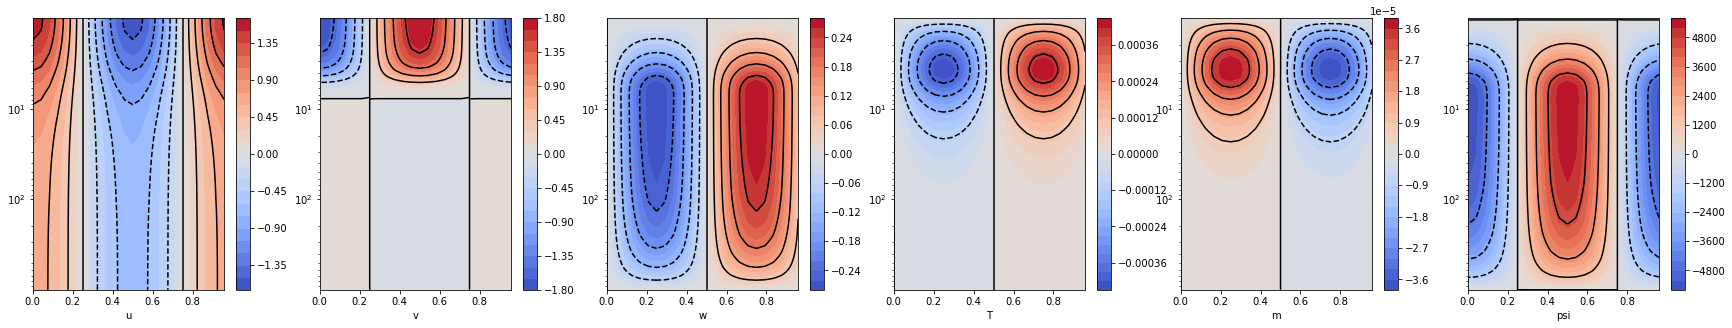

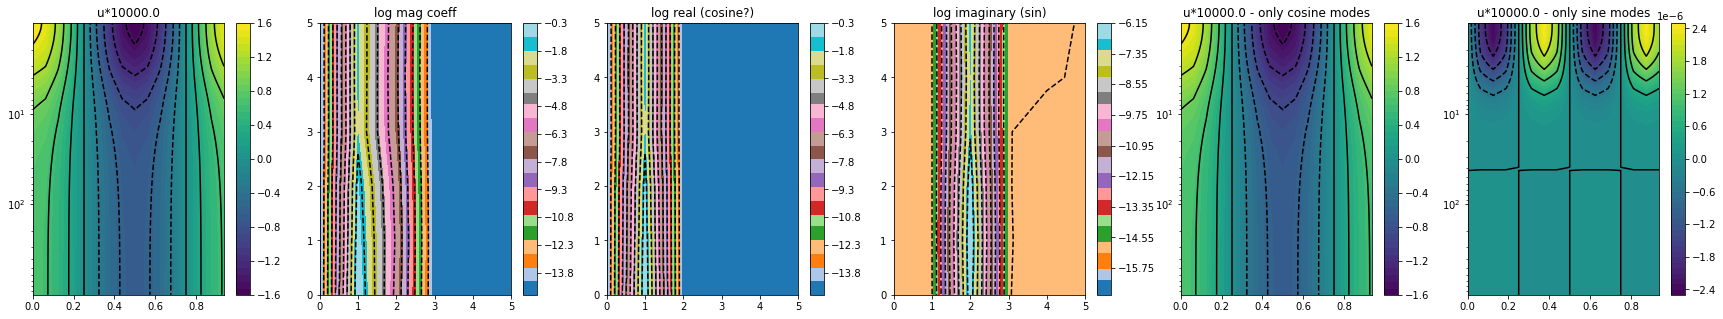

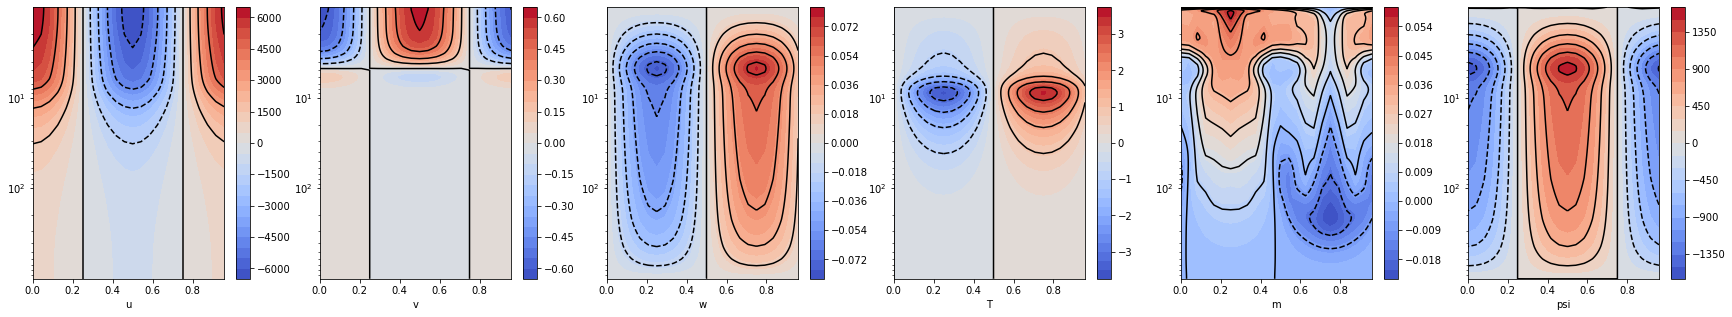

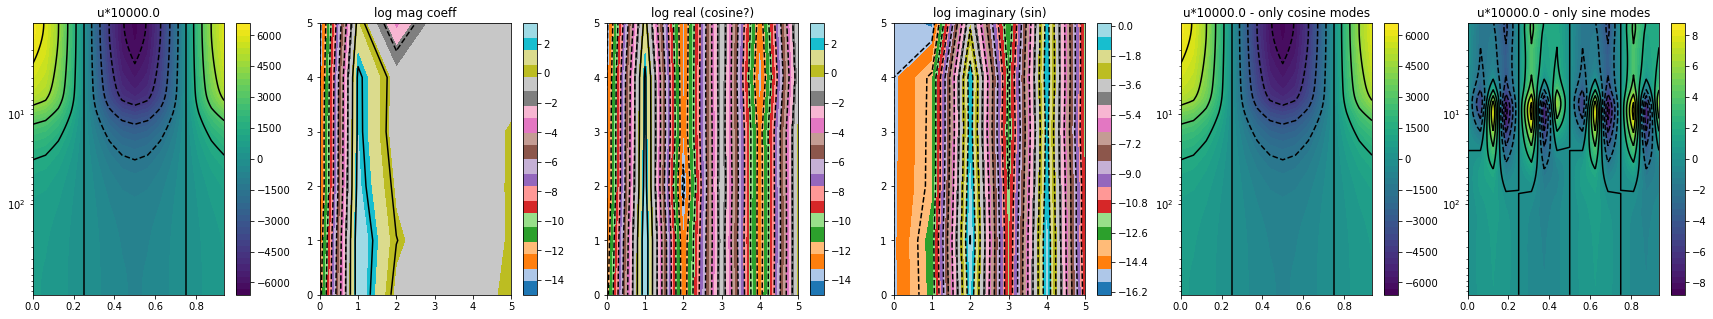

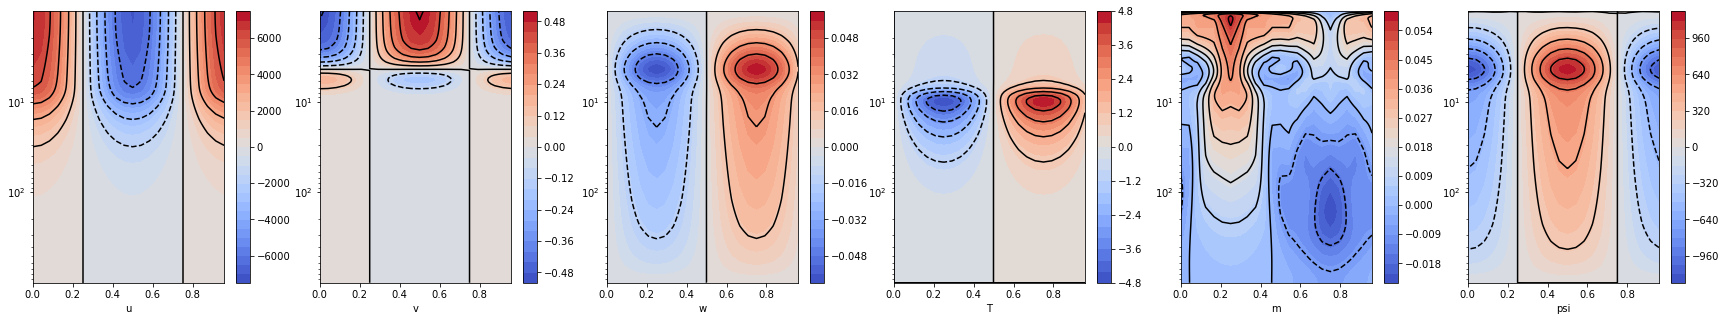

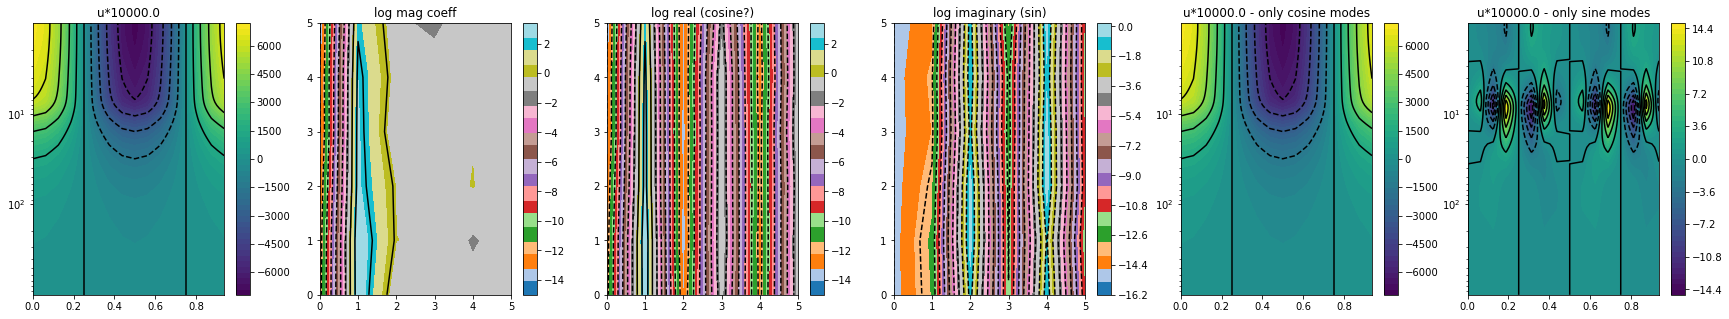

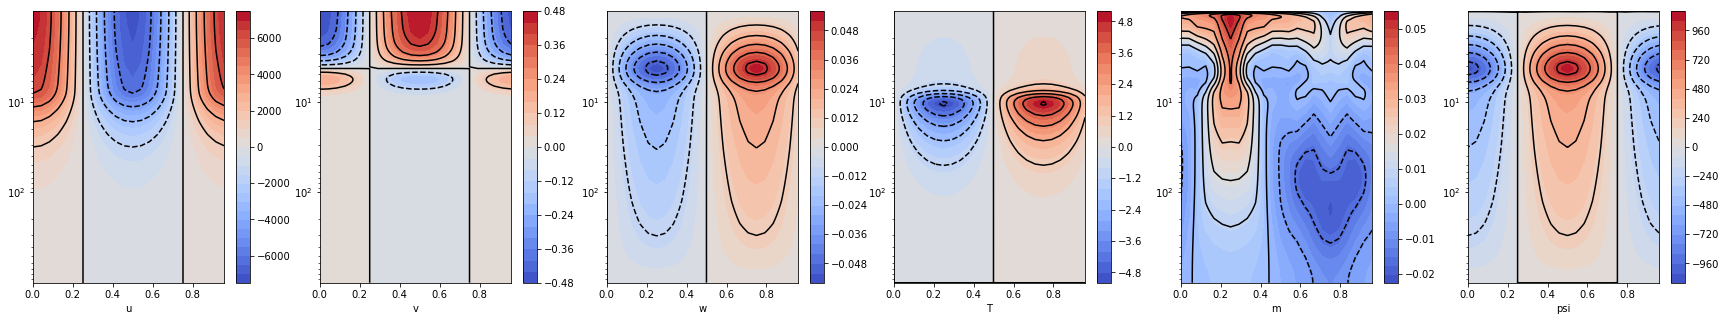

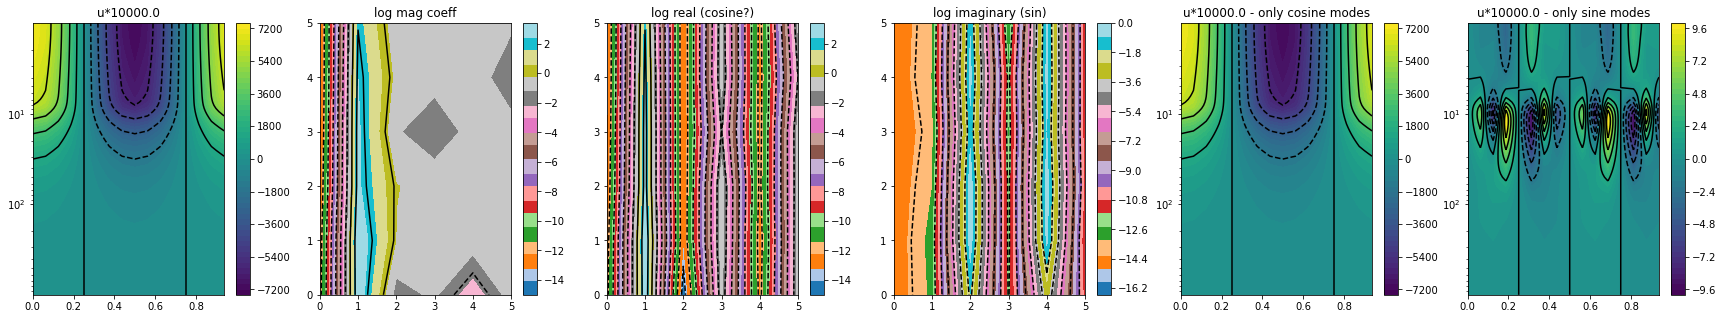

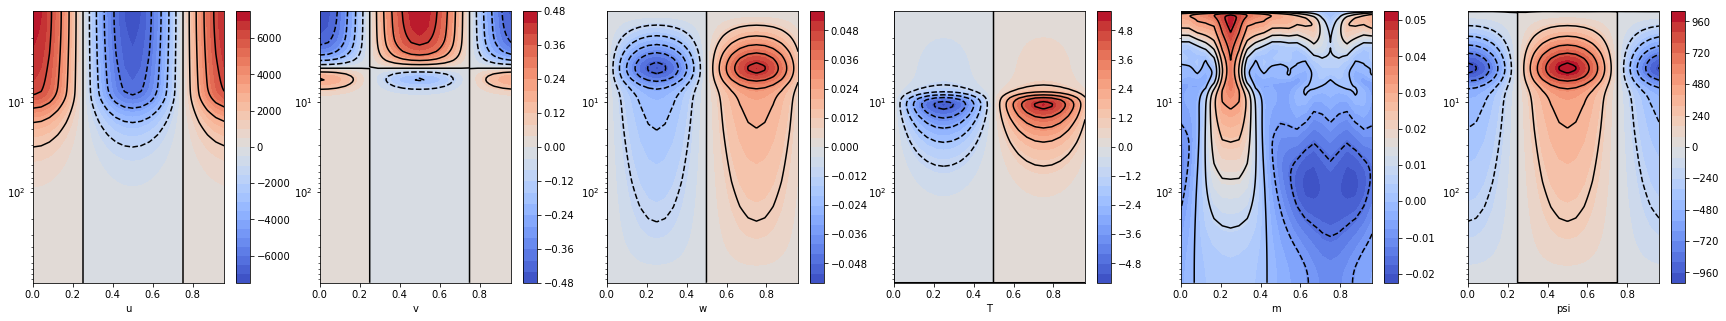

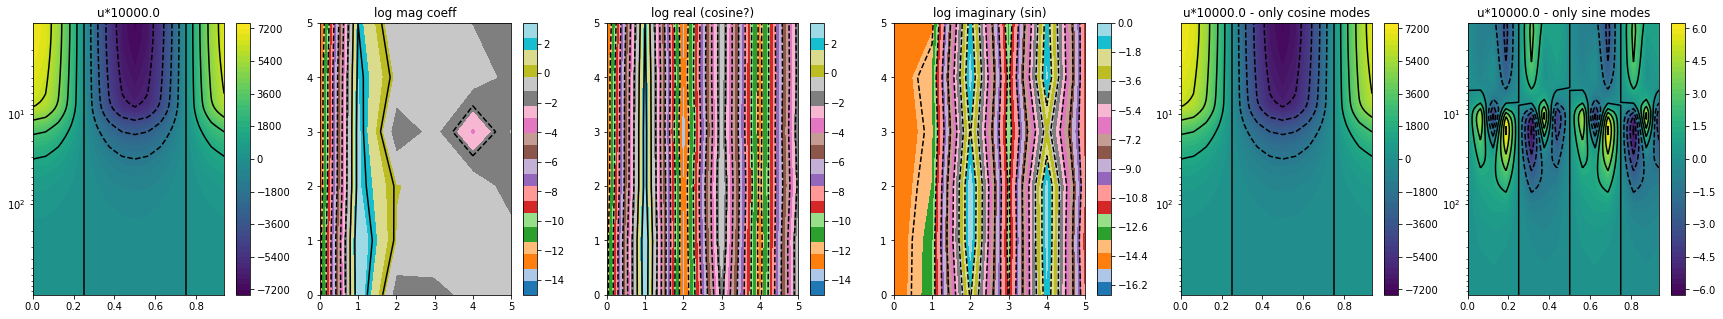

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from IPython import display

import os 

import numpy as np
import time

from dedalus import public as de
from dedalus.extras import flow_tools, plot_tools


mesh=[4,2]


import logging
logger = logging.getLogger(__name__)

# Constants
P_max = 1e3
P_min = 1
P_tach = 5

f = 1.8e-4
U_F = 1.0e4
F_time = 100 # years

N = 2e-4
H = 1e7
m_0 = 2.4
Rgas = 8.32e7 / m_0
R_time = 1e4 # years

alpha = 1e-2
Ly = 1.26e9
m_time = 1e4 # years

V = U_F / f / F_time
W = V * H / Ly
T_s = (N*H)**2 / (Rgas * H) * (R_time / F_time) * (U_F / f) * (H / Ly)
m_s = alpha / H * (m_time / F_time) * (U_F / f) * (H / Ly)

tau_0 = Ly/V # choose as the advective time scale for meridional circulation
Ro = U_F / (f * Ly)
Sc = m_time / F_time
alpha_bar = alpha / m_0

print("Values for the Juptier with alpha \n---------------- \nV: %e \nW: %e \nT_s: %e \nm_s: %e \ntau_hor: %e \ntau_vert: %e \nRossby (U_F / (f * Ly)): %e \nSchmidt (tau_mu / tau_fric): %e \nalpha_bar: %e \n------------------ \nRo.Sc: %e \nRo.Sc.alpha_bar: %e" %(V, W, T_s, m_s, Ly/V, H/W, Ro, Sc, alpha_bar, Ro*Sc, Ro*Sc*alpha_bar))

# bases + domain + grid
y_basis = de.Fourier('y', 16, interval=(0, 1), dealias=3/2)
z_basis = de.Chebyshev('z', 128, interval=(np.log(P_max/P_min), np.log(1)), dealias=3/2)

domain = de.Domain([y_basis, z_basis], grid_dtype=np.float64)
problem = de.IVP(domain, variables=['u','v','T','m','w','u_z', 'w_z','m_z'], ncc_cutoff=1e-14)

y_grid = domain.grid(0)
z_grid = domain.grid(1)

# domain dependent terms

def Heavyside(x):
    ktan= 0.5 # defines steepness of 0-1 transition in x=0
    return 0.5*(1. + np.tanh(ktan*x))

tau_F = domain.new_field(name='tau_F')
tau_F['g'] = F_time * 1e-2 / (1./3e7* Heavyside(P_tach / P_min - np.exp(z_grid)) + 1./3e9 )
tau_F.meta['y']['constant'] = True

tau_R = domain.new_field(name='tau_R')
tau_R['g'] = R_time * 1e-2 / (1./3e7* Heavyside(P_tach / P_min - np.exp(z_grid)) + 1./3e9 ) 
tau_R.meta['y']['constant'] = True

tau_m = domain.new_field(name='tau_m')
tau_m['g'] = m_time * 1e-2 / (1./3e7* Heavyside(P_tach / P_min - np.exp(z_grid)) + 1./3e9 )
tau_m.meta['y']['constant'] = True

U_Fric = domain.new_field(name='U_Fric')
U_Fric['g'] = Heavyside(P_tach / P_min - np.exp(z_grid)) * np.cos(2.* np.pi * y_grid)

problem.parameters['u_f'] = U_Fric  
problem.parameters['nuv'] = 1e-8
problem.parameters['nuh'] = 2e-6

problem.parameters['z1'] = f * V * tau_0 / U_F
problem.parameters['z2'] = tau_0 / tau_F

problem.parameters['t1'] = tau_0 * (N*H)**2 * W / (Rgas * H) / T_s
problem.parameters['t2'] = tau_0 / tau_R

problem.parameters['m1'] = alpha * W * tau_0 / (H * m_s)
problem.parameters['m2'] = tau_0 / tau_m
problem.parameters['m3'] = V * tau_0 / Ly
problem.parameters['m4'] = W * tau_0 / H

A = Rgas * T_s / (f * U_F * Ly) 
tau_0f = tau_0

# No time derivative in the following equations, so explicitly multiplied by tau_0
problem.parameters['tw0'] = 1 * (tau_0f)
problem.parameters['tw1'] = A * (tau_0f)
problem.parameters['tw2'] = A * m_s / m_0 * (tau_0f)

problem.parameters['c1'] = W / H * (tau_0f) # same as m4 when tau_f0 = tau_0
problem.parameters['c2'] = V / Ly * (tau_0f) # same as m3 when tau_f0 = tau_0
'''----------------------------------------------------------------------------------'''
print("Coefficients relevant for simulation:")
print("z1: %e \t z2: %e" %(problem.parameters['z1'], tau_0 / F_time))
print("t1: %e \t t2: %e" %(problem.parameters['t1'], tau_0 / R_time))
print("m1: %e \t m2: %e \t m3: %e \t m4: %e" %(problem.parameters['m1'], tau_0 / m_time, problem.parameters['m3'], problem.parameters['m4']))
print("tw1: %e \t tw2: %e" %(problem.parameters['tw1'], problem.parameters['tw2'])) 
print("c1: %e \t c2: %e" %(problem.parameters['c1'], problem.parameters['c2']))
# print("Note m3 and m4 are O(6) smaller than m1 and m2. Also, tw2 is O(9) smaller than tw1. \nThus we neither expect nonlinear mu advection, nor any nonlinear effect on the thermal wind.")

problem.add_equation("dt(u) - z1 * v = (u_f - u) * z2") 
problem.add_equation("dt(T) - t1 * w = (0 - T) * t2") 
problem.add_equation("dt(m) + m1 * w - nuv * dz(m_z) = (0 - m) * m2 - v * dy(m) * m3 - w * m_z * m4")
problem.add_equation("tw0 * u_z - tw1 * dy(T) = - tw2 * T * dy(m)") 
problem.add_equation("c1 * dy(v) + c2 * (w + w_z) + nuh * d(w,y=4) = 0")

problem.add_equation("dz(u) - u_z = 0")
problem.add_equation("dz(w) - w_z = 0")
problem.add_equation("dz(m) - m_z = 0")

problem.add_bc("left(w) = 0")
problem.add_bc("right(w) = 0", condition="(ny != 0)") # right is top
problem.add_bc("left(v) = 0", condition="(ny == 0)")
problem.add_bc("right(m) = 0")
problem.add_bc("left(m_z) = 0")

# Build solver
solver = problem.build_solver(de.timesteppers.RK222)
logger.info('Solver built')

# Initial conditions
y = domain.grid(0)
z = domain.grid(1)
u = solver.state['u']
v = solver.state['v']
T = solver.state['T']
w = solver.state['w']
m = solver.state['m']

u['g'] = 0. 
v['g'] = 0.
T['g'] = 0.
w['g'] = 0.
m['g'] = 0.

# Initial timestep
dt = 3e2

# Integration parameters
solver.stop_sim_time = np.inf 
solver.stop_wall_time = np.inf 
solver.stop_iteration = 5e4

# CFL
CFL = flow_tools.CFL(solver, initial_dt=dt, cadence=1, safety=0.2, max_change=1.1, min_change=0.9, max_dt=3.5e6, threshold=0.05)
CFL.add_velocities(('v', 'w'))

from scipy.integrate import cumtrapz
bar_cgs = 1e6

from matplotlib import colors

def plot(ax,field,fig,ym,zm,st):
#     divnorm=colors.TwoSlopeNorm(vmin=field.min(),vcenter=0.,vmax=field.max())
    p = ax.contourf(ym, zm, field.T, cmap='coolwarm', levels=30)#,norm=divnorm)
    ax.contour(ym, zm, field.T,colors='k', levels=10)
    ax.invert_yaxis()
    fig.colorbar(p,ax=ax)
    ax.set(xlabel=st)#, ylabel='z')
    ax.set_yscale('log')

def generate_field():
    
    z = np.exp(domain.grid(1,scales=domain.dealias)); y = domain.grid(0,scales=domain.dealias)
    ym, zm = np.meshgrid(y,z)
    
    uu = U_F * u['g']
    vv = V * v['g'] 
    ww = W * w['g'] * z 
    TT = T_s * T['g']
    mm = m_s * m['g']
    
    u_prof_plus.append(uu[int(0.0*len(uu))+10].copy()); u_prof_minus.append(uu[int(0.0*len(uu))-10].copy())

    fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1,6,figsize=(30,5))
    
    plot(ax1,uu,fig,ym,zm,'u');    plot(ax2,vv,fig,ym,zm,'v');    plot(ax3,ww,fig,ym,zm,'w');    plot(ax4,TT,fig,ym,zm,'T');    plot(ax5,mm,fig,ym,zm,'m')
    
    # Streamfunction psi
    psi = cumtrapz(vv,x=(z),initial=0)
    psi *= bar_cgs # use cgs unit for pressure for psi in cgs [g/s^3]
    psi *= 1e-3 # convert to [kg/s^3]
    plot(ax6,psi,fig,ym,zm,'psi')
    
def plott(ax,field,fig,st,cmp,f):
    if f == 0:# real space plots
        z = np.exp(domain.grid(1))
        ym, zm = np.meshgrid(y,z)
        p = ax.contourf(ym, zm, field.T, cmap=cmp, levels=50)
        ax.contour(ym, zm, field.T, colors='k', levels=10)
        ax.set_yscale('log')
        ax.invert_yaxis()
    else:# coefficient space plots
        p = ax.contourf(field.T, cmap=cmp, levels=100)
        ax.contour(field.T, colors='k', levels=10)
        ax.set_xlim([0, 5]); ax.set_ylim([0, 5]); 
    fig.colorbar(p,ax=ax)
    ax.title.set_text(st)

def examine():
    fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1,6,figsize=(30,5))
    name = u * U_F # just for string
    placeholder['c'] = u['c'] * U_F
    proxyfield['c'] = placeholder['c']

#     print(proxyfield['c'][1][1],proxyfield['c'][2][1])
#     print('\n log 10 real max:',np.log10(proxyfield['c'].real.max()),'real max:',proxyfield['c'].real.max())
#     print('log 10 imag max:',np.log10(proxyfield['c'].imag.max()),'imag max:',proxyfield['c'].imag.max())

    plott(ax1,proxyfield['g'],fig,str(name),'viridis',0);    plott(ax2,np.log10(abs(proxyfield['c'])+1e-15),fig,'log mag coeff','tab20',1);    
    plott(ax3,np.log10(abs(proxyfield['c'].real)+1e-15),fig,'log real (cosine?)','tab20',1);        plott(ax4,np.log10(abs(proxyfield['c'].imag+1e-15)),fig,'log imaginary (sin)','tab20',1);   

    proxyfield['c'].imag=0 # remove all sine modes
    plott(ax5,proxyfield['g'],fig,str(name)+' - only cosine modes','viridis',0); print(proxyfield['g'].max())
    proxyfield['c'] = placeholder['c'];   proxyfield['c'].real=0 # remove dominant cosine mode
    plott(ax6,proxyfield['g'],fig,str(name)+' - only sine modes','viridis',0)
    print(proxyfield['g'].max())

proxyfield = domain.new_field()
placeholder = domain.new_field()
u_prof_plus = []; u_prof_minus = []; # time = []

def calculate_kinetic_energy(u, v, w):
    return 0.5 * (v['g']**2 + w['g']**2 + u['g']**2).sum()

n = 0
kinetic_energy = []
time_a = []
try:
    logger.info('Starting loop')
    start_time = time.time()
    while solver.ok:
        t = solver.sim_time
        dt = CFL.compute_dt()
        dt = solver.step(dt)
        ke = calculate_kinetic_energy(solver.state['u'], solver.state['v'], solver.state['w'])
        kinetic_energy.append(ke)
        time_a.append(solver.sim_time*tau_0/3e7)
        if solver.iteration > n * solver.stop_iteration / 5:
            logger.info('Iteration: %i, Time: %e, dt: %e' %(solver.iteration, solver.sim_time, dt))
            generate_field()
            examine()
            n = n + 1
        
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    end_time = time.time()
    logger.info('Iterations: %i' %solver.iteration)
    logger.info('Sim end time: %f years' %(solver.sim_time*tau_0/3e7))
    logger.info('Run time: %.2f sec' %(end_time-start_time))
    logger.info('Run time: %f cpu-hr' %((end_time-start_time)/60/60*domain.dist.comm_cart.size))

12 6


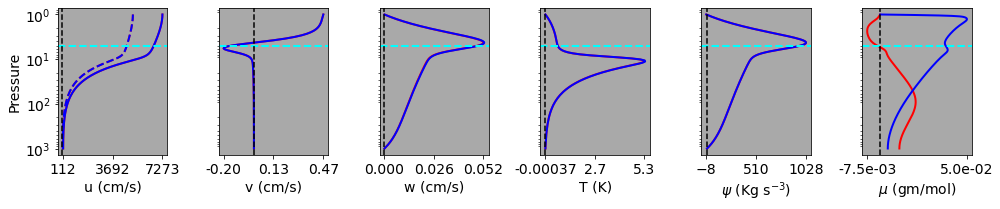

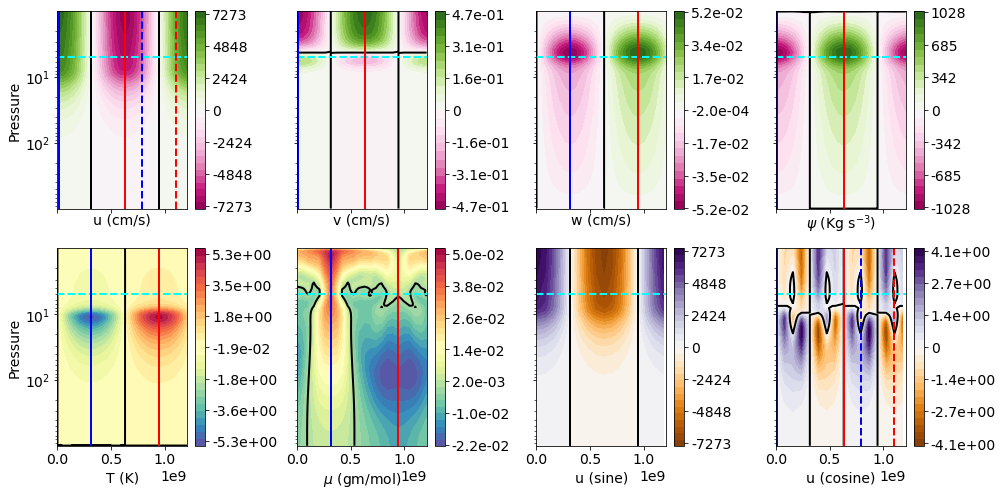

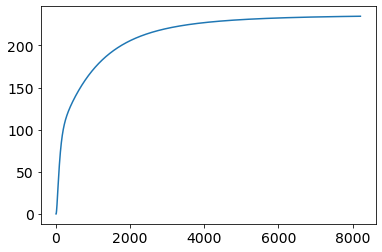

In [19]:
import matplotlib.ticker as ticker
import matplotlib 
from matplotlib.ticker import FormatStrFormatter

matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
z = np.squeeze(np.exp(domain.grid(1,scales=domain.dealias)))
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1,6,figsize=(14,3))

mid = int(len(domain.grid(0,scales=domain.dealias))*2/4)
qtr = int(len(domain.grid(0,scales=domain.dealias))*1/4)
threeqtr = int(len(domain.grid(0,scales=domain.dealias))*3/4)
fivei = int(len(domain.grid(0,scales=domain.dealias))*5/8)
sevei = int(len(domain.grid(0,scales=domain.dealias))*7/8)
print(mid,qtr)

ax1.plot(u['g'][0]*U_F,z,'r',linewidth=2)
ax1.plot(u['g'][sevei]*U_F,z,'r',linewidth=2,linestyle='--')
ax1.plot(-u['g'][mid]*U_F,z,'b',linewidth=2)
ax1.plot(-u['g'][fivei]*U_F,z,'b',linewidth=2,linestyle='--')
ax1.set_yscale('log')
ax1.set_xlabel('u (cm/s)', fontsize=14)
ax1.set_ylabel('Pressure',fontsize=14)
ax1.axhline(y = 5, color = 'cyan', linestyle = '--',linewidth=2)
ax1.axvline(x = 0, color = 'k', linestyle = '--',linewidth=1.5)
ax1.set_facecolor('darkgrey')
t = [u['g'][0].min()*U_F,u['g'][0].max()*U_F/2+u['g'][0].min()*U_F/2, u['g'][0].max()*U_F]
ax1.set_xticks(t)
ax1.invert_yaxis()

ax2.plot(v['g'][mid]*V,z,'r',linewidth=2)
ax2.plot(-v['g'][0]*V,z,'b',linewidth=2)
ax2.set_yscale('log')
ax2.set_xlabel('v (cm/s)', fontsize=14)
# ax2.set_ylabel('Pressure',fontsize=14)
t = [v['g'][mid].min()*V,v['g'][mid].max()*V/2+v['g'][mid].min()*V/2,v['g'][mid].max()*V]
ax2.axhline(y = 5, color = 'cyan', linestyle = '--',linewidth=2)
ax2.axvline(x = 0, color = 'k', linestyle = '--',linewidth=1.5)
ax2.set_xticks(t)
ax2.invert_yaxis()
ax2.set_yticks([])
ax2.set_facecolor('darkgrey')
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax3.plot(w['g'][threeqtr]*W*z,z,'r',linewidth=2)
ax3.plot(-w['g'][qtr]*W*z,z,'b',linewidth=2)
ax3.set_yscale('log')
ax3.set_xlabel('w (cm/s)', fontsize=14)
ax3.axhline(y = 5, color = 'cyan', linestyle = '--',linewidth=2)
ax3.axvline(x = 0, color = 'k', linestyle = '--',linewidth=1.5)
# ax3.set_ylabel('Pressure',fontsize=14)
t = [(w['g'][threeqtr]*z).min()*W,(w['g'][threeqtr]*z).max()*W/2+(w['g'][threeqtr]*z).min()*W/2,(w['g'][threeqtr]*z).max()*W]
ax3.set_xticks(t)
ax3.invert_yaxis()
ax3.set_yticks([])
ax3.set_facecolor('darkgrey')
ax3.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))

ax4.plot(T['g'][threeqtr]*T_s,z,'r',linewidth=2)
ax4.plot(-T['g'][qtr]*T_s,z,'b',linewidth=2)
ax4.set_yscale('log')
ax4.set_xlabel('T (K)', fontsize=14)
ax4.axhline(y = 5, color = 'cyan', linestyle = '--',linewidth=2)
ax4.axvline(x = 0, color = 'k', linestyle = '--',linewidth=1.5)
# ax4.set_ylabel('Pressure',fontsize=14)
t = [T['g'][threeqtr].min()*T_s,T['g'][threeqtr].max()*T_s/2+T['g'][threeqtr].min()*T_s/2,T['g'][threeqtr].max()*T_s]
ax4.set_xticks(t)
ax4.invert_yaxis()
ax4.set_yticks([])
ax4.set_facecolor('darkgrey')
formatter = ticker.FuncFormatter(custom_formatter)
ax4.xaxis.set_major_formatter(FormatStrFormatter('%.2g'))

# Streamfunction psi
a0 = 69800e5 # Jupiter radius in cm
g = 9.81e2 * 2.528 # Jupiter surface gravity in cgs (2.58 times Earth)
psi = cumtrapz(v['g']*V,x=(z),initial=0)
psi *= bar_cgs 
# psi *= 2*np.pi*a0/g # use cgs unit for pressure for psi in cgs [g/s^3]
psi *= 1e-3 # convert to [kg/s^3]
ax5.plot(psi[mid],z,'r',linewidth=2)
ax5.plot(-psi[0],z,'b',linewidth=2)
ax5.set_yscale('log')
ax5.set_xlabel('$\psi$ (Kg s$^{-3}$)', fontsize=14)
ax5.axhline(y = 5, color = 'cyan', linestyle = '--',linewidth=2)
ax5.axvline(x = 0, color = 'k', linestyle = '--',linewidth=1.5)
ax5.set_yticks([])
ax5.set_facecolor('darkgrey')
# ax5.set_ylabel('Pressure',fontsize=14)
t = [psi[mid].min(),(psi[mid].min()+psi[mid].max())/2,psi[mid].max()]
ax5.set_xticks(t)
ax5.invert_yaxis()

ax6.plot(-m['g'][threeqtr]*m_s,z,'r',linewidth=2)
ax6.plot(m['g'][qtr]*m_s,z,'b',linewidth=2)
ax6.set_yscale('log')
ax6.set_xlabel('$\mu$ (gm/mol)', fontsize=14)
ax6.axhline(y = 5, color = 'cyan', linestyle = '--',linewidth=2)
ax6.axvline(x = 0, color = 'k', linestyle = '--',linewidth=1.5)
t = [-m['g'][threeqtr].max()*m_s, m['g'][qtr].max()*m_s]
ax6.set_xticks(t)
ax6.invert_yaxis()
ax6.set_yticks([])
ax6.set_facecolor('darkgrey')
formatter = ticker.FuncFormatter(custom_formatter)
ax6.xaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.savefig('T2-a.pdf')

def plot(ax,field,fig,ym,zm,st,cmap):
#     divnorm=colors.TwoSlopeNorm(vmin=field.min(),vcenter=0.,vmax=field.max())
    p = ax.contourf(ym, zm, field.T, cmap=cmap, levels = 30)#, norm=divnorm, ls=None)
    ax.contour(ym, zm, field.T,colors='k',levels = [0],linewidths=2)
    ax.axhline(y = 5, color = 'cyan', linestyle = '--',linewidth=2)
    if st == 'u (cm/s)' or st == 'v (cm/s)' or st == '$\psi$ (Kg s$^{-3}$)' or st == 'u (cosine)':
        ax.axvline(Ly/2, color = 'red', linestyle = '-',linewidth=2)
        ax.axvline(0.01*Ly, color = 'blue', linestyle = '-',linewidth=2)
        if st == 'u (cm/s)' or st == 'u (cosine)':
            ax.axvline(5*Ly/8, color = 'b', linestyle = '--',linewidth=2)
            ax.axvline(7*Ly/8, color = 'r', linestyle = '--',linewidth=2)
    elif st == 'w (cm/s)' or st == 'T (K)' or st == '$\mu$ (gm/mol)':
        ax.axvline(3*Ly/4, color = 'red', linestyle = '-',linewidth=2)
        ax.axvline(1*Ly/4, color = 'blue', linestyle = '-',linewidth=2)
    cbar = fig.colorbar(p,ax=ax)
    cbar.set_ticks(np.linspace(field.min(),field.max(),7))
    # Use a formatter to manage small numbers
    formatter = ticker.FuncFormatter(custom_formatter)
    cbar.ax.yaxis.set_major_formatter(formatter)
    ax.set_xlabel(st,fontsize=14)
    if(ax==axs[0,0] or ax==axs[1,0]):
        ax.set_ylabel('Pressure',fontsize=14)
    ax.set_yscale('log')
    
# Use a formatter to show 0 for very small numbers
def custom_formatter(x, pos):
    if abs(x) < 1e-4:  # Adjust the threshold as needed
        return '0'
    elif abs(x) > 10:
        return str(int(x))
    else:
        return '{:.1e}'.format(x)
    
z = np.exp(domain.grid(1,scales=domain.dealias)); y = domain.grid(0,scales=domain.dealias)*Ly
ym, zm = np.meshgrid(y,z)

uu = U_F * u['g']
vv = V * v['g'] 
ww = W * w['g'] * z 
TT = T_s * T['g']
mm = m_s * m['g']

u_prof_plus.append(uu[int(0.0*len(uu))+10].copy()); u_prof_minus.append(uu[int(0.0*len(uu))-10].copy())

fig, axs = plt.subplots(2, 4, sharex='all', sharey='all',figsize=(14,7))
plot(axs[0,0],uu,fig,ym,zm,'u (cm/s)','PiYG');    plot(axs[0,1],vv,fig,ym,zm,'v (cm/s)','PiYG');    plot(axs[0,2],ww,fig,ym,zm,'w (cm/s)','PiYG');   
# Streamfunction psi
psi = cumtrapz(vv,x=(z),initial=0)
psi *= bar_cgs # use cgs unit for pressure for psi in cgs [g/s^3]
psi *= 1e-3 # convert to [kg/s^3]
plot(axs[0,3],psi,fig,ym,zm,'$\psi$ (Kg s$^{-3}$)','PiYG')

plot(axs[1,0],TT,fig,ym,zm,'T (K)' ,'Spectral_r');      plot(axs[1,1],mm,fig,ym,zm,'$\mu$ (gm/mol)','Spectral_r')

z = np.exp(domain.grid(1)); y = domain.grid(0)*Ly
ym, zm = np.meshgrid(y,z)

placeholder['c'] = u['c'] * U_F
proxyfield['c'] = placeholder['c']
proxyfield['c'].imag=0 # remove all sine modes
plot(axs[1,2],proxyfield['g'],fig,ym,zm,'u (sine)','PuOr')

proxyfield['c'] = placeholder['c'];   proxyfield['c'].real=0 # remove dominant cosine mode
plot(axs[1,3],proxyfield['g'],fig,ym,zm,'u (cosine)','PuOr');

axs[0,0].invert_yaxis()

plt.tight_layout()
plt.savefig('T2-b.pdf')

plt.figure()
plt.plot(time_a, kinetic_energy)